In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

DATA_PATH = "../data/processed/"
df = pd.read_csv(DATA_PATH + "m5_features.csv")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["id", "date"]).reset_index(drop=True)

df.head()

,id,item_id,dept_id,store_id,state_id,d,sales,date,weekday,wday,...,is_weekend,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,has_event
0,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,CA_1,CA,d_40,0,2011-03-09,Wednesday,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,CA_1,CA,d_47,0,2011-03-16,Wednesday,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,CA_1,CA,d_48,0,2011-03-17,Thursday,6,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,CA_1,CA,d_51,0,2011-03-20,Sunday,2,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,CA_1,CA,d_86,0,2011-04-24,Sunday,2,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [26]:
TEST_DAYS = 28

def train_test_split_ts(df, test_days):
    train_dfs = []
    test_dfs = []

    for _, g in df.groupby("id"):
        train_dfs.append(g.iloc[:-test_days])
        test_dfs.append(g.iloc[-test_days:])

    return pd.concat(train_dfs), pd.concat(test_dfs)


train_df, test_df = train_test_split_ts(df, TEST_DAYS)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

Train shape: (615, 25)
Test shape : (140, 25)


In [30]:
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAPE": np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    }

In [31]:
naive_preds = []

for pid, g_test in test_df.groupby("id"):
    last_train_value = (
        train_df[train_df["id"] == pid]
        .iloc[-1]["sales"]
    )
    naive_preds.extend([last_train_value] * len(g_test))

test_df["naive_forecast"] = naive_preds

In [32]:
naive_metrics = evaluate(
    test_df["sales"],
    test_df["naive_forecast"]
)

naive_metrics

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 29.185714285714287,
 'RMSE': 34.71784226343238,
 'MAPE': 46071428650.982544}

In [35]:
WINDOW = 7
ma_preds = []

for pid, g_test in test_df.groupby("id"):
    g_train = train_df[train_df["id"] == pid]

    last_values = g_train["sales"].iloc[-WINDOW:]
    ma_value = last_values.mean()

    ma_preds.extend([ma_value] * len(g_test))

test_df["ma_7_forecast"] = ma_preds

In [16]:
ma_metrics = evaluate(
    test_df["sales"],
    test_df["ma_7_forecast"]
)

ma_metrics

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 23.293877551020408,
 'RMSE': 30.627751854706368,
 'MAPE': 28173469439.968914}

In [37]:
baseline_results = pd.DataFrame([
    {"Model": "Naive (Last Value)", **naive_metrics},
    {"Model": "Moving Average (7d)", **ma_metrics}
])

baseline_results

,Model,MAE,RMSE,MAPE
0,Naive (Last Value),29.185714,34.717842,4.607143e+10
1,Moving Average (7d),23.293878,30.627752,2.817347e+10


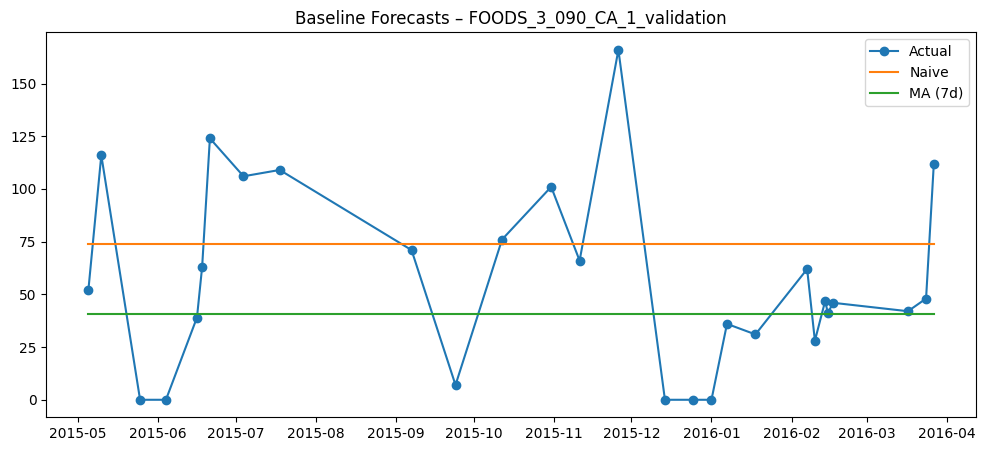

In [39]:
sample_id = test_df["id"].iloc[0]
sample = test_df[test_df["id"] == sample_id]

plt.figure(figsize=(12,5))
plt.plot(sample["date"], sample["sales"], label="Actual", marker="o")
plt.plot(sample["date"], sample["naive_forecast"], label="Naive")
plt.plot(sample["date"], sample["ma_7_forecast"], label="MA (7d)")
plt.title(f"Baseline Forecasts – {sample_id}")
plt.legend()
plt.show()